# Merge emissions table created in /food_emissions with all other "food and country" tables

After manual inspection of all food/country tables:

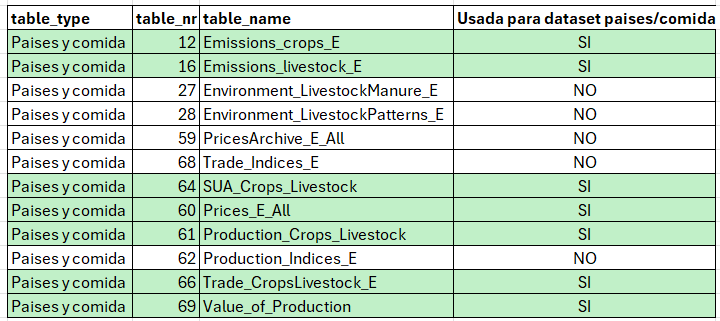


## Features to extract:

64	SUA_Crops_Livestock:
- Protein supply quantity (g/capita/day), Food supply quantity (tonnes), Food supply (kcal/capita/day), Food supply quantity (g/capita/day), Tourist consumption

60	Prices_E_All:
- Producer Price (USD/tonne)

61	Production_Crops_Livestock:
- Area harvested, Production, Yield

66	Trade_CropsLivestock_E:
- Export Value, Import Value, Export Quantity, Import Quantity

69	Value_of_Production:
- Gross Production Value (current thousand US$)


In [100]:
import pandas as pd
import numpy as np
import zipfile
import io
import os

#supress warnings
import warnings
warnings.filterwarnings('ignore')

In [101]:
def load_fao_table(table_number, path):
    # Loop through all files in the directory
    for filename in os.listdir(path):
        # Extract the number from the start of the filename
        file_number_str = filename.split('-')[0]
        try:
            file_number = int(file_number_str)
            # Check if the number matches the table number
            if file_number == table_number:
                full_path = os.path.join(path, filename)

                if filename.endswith(".zip"):
                    # Open the zip file
                    with zipfile.ZipFile(full_path, 'r') as zip_ref:
                        # Iterate through the file names in the zip archive
                        for file_name in zip_ref.namelist():
                            # Check if the file name contains the pattern "All_Data_" and ends with .csv
                            if "All_Data" in file_name and file_name.endswith(".csv"):
                                # Read the CSV file into a DataFrame
                                with zip_ref.open(file_name) as file:
                                    return pd.read_csv(file, encoding="ISO-8859-1")

                elif filename.endswith(".csv"):
                    # Read the CSV file into a DataFrame
                    return pd.read_csv(full_path, encoding="ISO-8859-1")

        except ValueError:
            # Handle the case where the filename doesn't start with a valid number
            continue
    
    # Return None if no matching file is found
    return None

## Load merged emissions dataset

In [102]:
emissions_df = pd.read_parquet(r'..\data\FAOSTAT\clean_data\all_tables_processed\food_emissions\merged_food_emissions_v2.parquet')

## Load table with new MORE GENERAL items

Most food tables have specific items like "meat of cattle", etc.

I will change all of these to the more general terms used in EMISSIONS TABLES: por ex. "Cattle, dairy"

Create a dictionary to change super specific item names to more general names

In [103]:
new_items_df = pd.read_csv(r'..\data\FAOSTAT\clean_data\food_codes_categorized_final.csv', encoding = 'ISO-8859-1')
new_items_df.dropna(subset='Item_emissions_table', inplace=True)
new_items_df['Item_code_emissions_table'] = new_items_df['Item_code_emissions_table'].astype('int64')

In [104]:
# I saw some changes between tables. Just in case I will use ALL item codes and items and an "OR CONDITIONAL"
all_item_codes = list(new_items_df['Item_Code'].unique()) + list(new_items_df['Item_code_emissions_table'].unique())
print(len(all_item_codes))

all_items = list(new_items_df['Item'].unique()) + list(new_items_df['Item_emissions_table'].unique())
print(len(all_items))

140
140


## Load food and country tables and extract features

Iterate through selected food and country tables and extract features to merge with emissions table

In [8]:
directory = r'..\data\FAOSTAT\all_raw'

In [9]:
selected_tables = [64, 60, 61, 66, 69]

In [10]:
selected_elements = [
    "Protein supply quantity (g/capita/day)",
    "Food supply quantity (tonnes)",
    "Food supply (kcal/capita/day)",
    "Food supply quantity (g/capita/day)",
    "Tourist consumption",
    "Producer Price (USD/tonne)",
    "Area harvested",
    "Production",
    "Yield",
    "Export Value",
    "Import Value",
    "Export Quantity",
    "Import Quantity",
    "Gross Production Value (current thousand US$)"
]

In [27]:
merged_df = pd.DataFrame()

for table in selected_tables:
    # Load the data
    df = load_fao_table(table, directory)

    # select food items in emissions table
    df = df[df['Item Code'].isin(all_item_codes)]# | df['Item'].isin(all_items)].copy()

    # Select elements defined in the beginning
    df = df[df['Element'].isin(selected_elements)]
    
    # Replace spaces and commas in column names
    cols_with_spaces = ['Element', 'Unit']
    for col in cols_with_spaces:
        df[col] = df[col].str.replace(' ', '_').str.replace(',', '_')

    # Combine 'Element' and 'Unit' columns
    df['Element'] = df['Element'] + "_" + df['Unit']

    # Group by Area, Year, Item, and Element, then sum the values
    grouped = df.groupby(['Area Code', 'Area', 'Year', 'Item Code', 'Item', 'Element'])['Value'].sum().reset_index()

    # Pivot the table to have combinations of Items and Elements as columns
    pivot_df = grouped.pivot_table(index=['Area Code', 'Area', 'Year', 'Item Code', 'Item'], 
                                    columns=['Element'], 
                                    values='Value', 
                                    aggfunc='sum').reset_index()

    if merged_df.empty:
        merged_df = pivot_df
    else:
        merged_df = pd.merge(merged_df, pivot_df, on=['Area Code', 'Area', 'Year', 'Item Code', 'Item'], how='outer')

In [30]:
merged_df.to_parquet(r'..\data\FAOSTAT\clean_data\all_tables_processed\full_food_dataset_v1.parquet', index=False)

# Convert specific items to aggregated items and aggregate by item ,year and area

In [133]:
merged_df = pd.read_parquet(r'..\data\FAOSTAT\clean_data\all_tables_processed\full_food_dataset_v1.parquet')

In [134]:
merged_df.drop(columns=['Export_Quantity_t_x', 'Production_t_x', 'Import_Quantity_t_x'], inplace=True)

In [135]:
""" stacked_corr = merged_df.corr(numeric_only=True).stack().reset_index()
# Rename the columns for better readability
stacked_corr.columns = ['Feature 1', 'Feature 2', 'Correlation']
#Filter out self-correlations
filtered_corr = stacked_corr[stacked_corr['Feature 1'] != stacked_corr['Feature 2']]

filtered_corr.sort_values(by='Correlation', ascending=False).head(10) """

" stacked_corr = merged_df.corr(numeric_only=True).stack().reset_index()\n# Rename the columns for better readability\nstacked_corr.columns = ['Feature 1', 'Feature 2', 'Correlation']\n#Filter out self-correlations\nfiltered_corr = stacked_corr[stacked_corr['Feature 1'] != stacked_corr['Feature 2']]\n\nfiltered_corr.sort_values(by='Correlation', ascending=False).head(10) "

In [136]:
# merged_df[merged_df['Year'] == 2021].to_csv('merged_df_2021.csv', index=False)
# emissions_df[emissions_df['Year'] == 2021].to_csv('emissions_df_2021.csv', index=False)

In [137]:
# Merge with new agreggated items from emissions table
merged_df_new_items = pd.merge(merged_df, new_items_df, left_on='Item Code', right_on='Item_Code', how='left')

In [138]:
# Define columns to aggregate and columns to sum
group_by_columns = ['Area Code', 'Area', 'Year', 'Item_code_emissions_table', 'Item_emissions_table']

sum_columns = merged_df_new_items.columns.to_list()[5:27]
print(sum_columns)

['Food_supply_(kcal/capita/day)_kcal/cap/d', 'Food_supply_quantity_(g/capita/day)_g/cap/d', 'Food_supply_quantity_(tonnes)_t', 'Protein_supply_quantity_(g/capita/day)_g/cap/d', 'Tourist_consumption_t', 'Producer_Price_(USD/tonne)_USD', 'Area_harvested_ha', 'Production_1000_No', 'Production_t_y', 'Yield_100_g/An', 'Yield_100_g/ha', 'Yield_100_mg/An', 'Yield_No/An', 'Export_Quantity_1000_An', 'Export_Quantity_An', 'Export_Quantity_t_y', 'Export_Value_1000_USD', 'Import_Quantity_1000_An', 'Import_Quantity_An', 'Import_Quantity_t_y', 'Import_Value_1000_USD', 'Gross_Production_Value_(current_thousand_US$)_1000_USD']


In [139]:
aggregated_df = merged_df_new_items.groupby(group_by_columns)[sum_columns].sum().reset_index()

In [140]:
aggregated_df.sample(5)

,Area Code,Area,Year,Item_code_emissions_table,Item_emissions_table,Food_supply_(kcal/capita/day)_kcal/cap/d,Food_supply_quantity_(g/capita/day)_g/cap/d,Food_supply_quantity_(tonnes)_t,Protein_supply_quantity_(g/capita/day)_g/cap/d,Tourist_consumption_t,...,Yield_No/An,Export_Quantity_1000_An,Export_Quantity_An,Export_Quantity_t_y,Export_Value_1000_USD,Import_Quantity_1000_An,Import_Quantity_An,Import_Quantity_t_y,Import_Value_1000_USD,Gross_Production_Value_(current_thousand_US$)_1000_USD
92262,98,Croatia,2017,1757,Cattle,0.00,0.00,0.00,0.00,0.0,...,0.0,0.0,133977.0,0.00,156613.0,0.0,137463.0,0.00,84105.0,0.0
229327,235,Uzbekistan,2009,83,Sorghum,0.00,0.00,0.00,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0
174618,179,Qatar,2012,15,Wheat,0.00,0.00,0.00,0.00,0.0,...,0.0,0.0,0.0,8151.00,4523.0,0.0,0.0,230335.00,85514.0,0.0
1504,2,Afghanistan,2016,15,Wheat,1377.11,381.47,4822649.65,41.58,0.0,...,0.0,0.0,0.0,88.77,43.0,0.0,0.0,2315422.74,608416.0,0.0
120165,122,Lesotho,1974,1052,Chickens; layers,0.00,0.00,0.00,0.00,0.0,...,56.0,0.0,0.0,0.00,0.0,0.0,0.0,84.00,224.0,0.0


# Merge with emissions table

Also aggregate by item and year (loosing country data)

In [141]:
# Define columns to aggregate and columns to sum
group_by_columns = ['Area Code', 'Area', 'Year', 'Item Code', 'Item', 'crops_or_livestock']

sum_columns = [col for col in emissions_df.columns if col not in group_by_columns+['Area Code', 'Area']]
print(sum_columns)

['Stocks_(An)', 'Burning_crop_residues_(Emissions_CH4_CO2eq)_(kt)', 'Burning_crop_residues_(Emissions_N2O_CO2eq)_(kt)', 'Crop_residues_(Emissions_N2O_CO2eq)_(kt)', 'Crops_total_(Emissions_CH4_CO2eq)_(kt)', 'Crops_total_(Emissions_N2O_CO2eq)_(kt)', 'Rice_cultivation_(Emissions_CH4_CO2eq)_(kt)', 'Synthetic_fertilizers_(Emissions_N2O_CO2eq)_(kt)', 'Emissions_(N2O_CO2eq)_(Manure_applied)_(kt)', 'Enteric_fermentation_(Emissions_CH4_CO2eq)_(kt)', 'Livestock_total_(Emissions_CH4_CO2eq)_(kt)', 'Livestock_total_(Emissions_N2O_CO2eq)_(kt)', 'Manure_left_on_pasture_(Emissions_N2O_CO2eq)_(kt)', 'Manure_management_(Emissions_CH4_CO2eq)_(kt)', 'Manure_management_(Emissions_N2O_CO2eq)_(kt)', 'production_TOTAL_(emissions_CO2eq)_(kt)']


In [142]:
aggregated_df_emissions = emissions_df.groupby(group_by_columns)[sum_columns].sum().reset_index()

In [168]:
full_food_df = pd.merge(aggregated_df_emissions, aggregated_df, 
                        left_on=['Area Code', 'Area', 'Year', 'Item Code'],
                        right_on=['Area Code', 'Area', 'Year', 'Item_code_emissions_table'],
                        how='inner')

In [169]:
print(aggregated_df.shape)
print(aggregated_df_emissions.shape)
print(f'Final shape: {full_food_df.shape}')

(320982, 27)
(252987, 22)
Final shape: (232040, 46)


In [175]:
#Save sample to check manually
full_food_df[(full_food_df['Year'] == 2021) & (full_food_df['Area'] == 'World')].to_csv('2021_food_test.csv', index=False)

## Remove items: Cattle, Chickens, Poultry Birds

Whole animal items. They don`t contain information about production, yield, etc. 

In [170]:
whole_animal_items = [1054,1757,2029]

full_food_df = full_food_df[~full_food_df['Item_code_emissions_table'].isin(whole_animal_items)]

## Remove columns without data for most items

After manual inspection

In [171]:
column_names = [
    "Item_code_emissions_table",
    "Item_emissions_table",
    "Producer_Price_(USD/tonne)_USD",
    "Production_1000_No",
    "Yield_100_g/An",
    "Yield_100_mg/An",
    "Yield_No/An",
    "Export_Quantity_1000_An",
    "Export_Quantity_An",
    "Import_Quantity_1000_An",
    "Import_Quantity_An"
]

full_food_df = full_food_df.drop(columns=column_names)

In [174]:
full_food_df.to_parquet(r'..\data\FAOSTAT\clean_data\all_tables_processed\full_food_dataset_v2_aggregated_byitem.parquet', index=False)